# Credit Card Routing for Online Purchase via Predictive Modelling

## Understanding Data

In [1]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 500)

%matplotlib inline

In [2]:
# Supressing the warnings

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Loading the dataset

ccr_ds = pd.read_excel("PSP_Jan_Feb_2019.xlsx", index_col = 0)

In [4]:
# Inspecting the head of the dataset

ccr_ds.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [5]:
# Checking the total number of rows and columns of the dataset

print("Dataset shape:", ccr_ds.shape)

Dataset shape: (50410, 7)


In [6]:
# Inspecting the descriptive information of the dataset

ccr_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


In [7]:
# Inspecting the statistical details of the dataset

ccr_ds.describe()

,amount,success,3D_secured
count,50410.000000,50410.000000,50410.000000
mean,202.395715,0.202896,0.238266
std,96.274730,0.402160,0.426027
min,6.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000
50%,201.000000,0.000000,0.000000
75%,269.000000,0.000000,0.000000
max,630.000000,1.000000,1.000000


In [8]:
# Checking the columns

print(ccr_ds.columns)

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card'], dtype='object')


In [9]:
# Checking the datatypes

print(ccr_ds.dtypes)

tmsp          datetime64[ns]
country               object
amount                 int64
success                int64
PSP                   object
3D_secured             int64
card                  object
dtype: object


## Exploratory Data Analysis

In [10]:
# Checking for the null values in the dataset

ccr_ds.isnull().sum()

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

In [11]:
# Checking the columns for unique values in the dataset

ccr_ds.nunique()

tmsp          50121
country           3
amount          517
success           2
PSP               4
3D_secured        2
card              3
dtype: int64

In [12]:
# Checking the duplicates in the dataset

ccr_ds.duplicated().sum()

81

In [13]:
# Printing the unique values

for column in ["country", "success", "PSP", "3D_secured", "card"]:
    print(column, "-", ccr_ds[column].unique())

country - ['Germany' 'Austria' 'Switzerland']
success - [0 1]
PSP - ['UK_Card' 'Simplecard' 'Moneycard' 'Goldcard']
3D_secured - [0 1]
card - ['Visa' 'Diners' 'Master']


In [14]:
# Dropping the duplicates

ccr_ds.drop_duplicates(inplace = True)

In [15]:
# Checking the total number of rows and columns of the dataset

print(ccr_ds.shape)

(50329, 7)


In [16]:
# Loading PSP transaction fees data into a dataframe

ccr_ds1 = pd.DataFrame({"PSP" : ["Moneycard", "Goldcard", "UK_Card", "Simplecard"], 
                    "success_txnFee":[5, 10, 3, 1],
                    "failure_txnFee":[2, 5, 1, 0.5]
                   })
display(ccr_ds1.head())

,PSP,success_txnFee,failure_txnFee
0,Moneycard,5,2.0
1,Goldcard,10,5.0
2,UK_Card,3,1.0
3,Simplecard,1,0.5


In [17]:
# Merging both into a single dataframe 

merged_ds = pd.merge(ccr_ds, ccr_ds1, on = "PSP")
merged_ds.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0
4,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,3,1.0


In [18]:
# Sorting the dataframe by the timestamp

merged_ds.sort_values(["tmsp"], inplace = True) 

In [19]:
# Finding the difference between consecutive timestamps 

merged_ds["timestamp_difference"] = merged_ds["tmsp"] - merged_ds["tmsp"].shift(1) 
merged_ds.reset_index(inplace = True)
merged_ds.drop(["index"], axis = 1, inplace = True)

In [20]:
# Converting the difference into seconds

merged_ds["timestamp_difference"]  = merged_ds["timestamp_difference"].apply(lambda x: x.total_seconds())

In [21]:
# Assigning 1 if transaction is done within a minute after the previous transaction and 0 if not

merged_ds["within_a_minute"] =  merged_ds["timestamp_difference"].apply(lambda x : 1 if x <= 60 else 0)

In [22]:
# ‘number_of_attempts’ to get the attempt count based on the given criteria and assigning an initial value of 1

merged_ds["number_of_attempts"] = 1

In [23]:
# Incrementing the 'number_of_attempts' if within_a_minute is 1

for i, r in merged_ds.iterrows():
     if i < merged_ds.shape[0] - 1:
          if (merged_ds["country"][i] == merged_ds["country"][i + 1]) & (merged_ds["amount"][i] == merged_ds["amount"][i + 1]) & (merged_ds["within_a_minute"][i + 1] <= 60):
            merged_ds["number_of_attempts"][i + 1] = merged_ds["number_of_attempts"][i] + 1

In [24]:
# Inspecting the dataset

merged_ds.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,timestamp_difference,within_a_minute,number_of_attempts
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,NaN,0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,6.0,1,2
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,92.0,0,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,24.0,1,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,80.0,0,1


In [25]:
# Extracting the month, day and hour 

merged_ds[['Month', 'Day', 'Hour']] = merged_ds['tmsp'].apply(lambda x : pd.Series([x.month, x.day, x.hour]))

In [26]:
# Mapping numeric value to weekday name

merged_ds['Weekday'] = merged_ds['tmsp'].dt.dayofweek.map({0 : 'Monday', 1 : 'Tuesday', 2 : 'Wednesday', 3 : 'Thursday', 4 : 'Friday', 5 : 'Saturday', 6 : 'Sunday'})

In [27]:
# Inspecting the dataset

merged_ds.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,timestamp_difference,within_a_minute,number_of_attempts,Month,Day,Hour,Weekday
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,NaN,0,1,1,1,0,Tuesday
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,6.0,1,2,1,1,0,Tuesday
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,92.0,0,1,1,1,0,Tuesday
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,24.0,1,2,1,1,0,Tuesday
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,80.0,0,1,1,1,0,Tuesday


In [28]:
# Performing label encoding


import copy
merged_ds["timestamp_difference"] = merged_ds["timestamp_difference"].fillna(0)
merged_ds.drop(['timestamp_difference', 'within_a_minute'], axis = 1, inplace = True)


from sklearn.preprocessing import LabelEncoder
le_ds = copy.deepcopy(merged_ds)
categorical_cols = ["country", "PSP", "card", "Weekday"]
label_encoder = LabelEncoder()
for cat_col in categorical_cols:
        le_ds[cat_col] = label_encoder.fit_transform(le_ds[cat_col])
        print(cat_col, ":", label_encoder.classes_)
le_ds.sample(5)

country : ['Austria' 'Germany' 'Switzerland']
PSP : ['Goldcard' 'Moneycard' 'Simplecard' 'UK_Card']
card : ['Diners' 'Master' 'Visa']
Weekday : ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']


,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,number_of_attempts,Month,Day,Hour,Weekday
16642,2019-01-19 09:51:01,1,42,0,3,0,2,3,1.0,1,1,19,9,2
33631,2019-02-08 03:49:54,0,291,0,3,0,1,3,1.0,2,2,8,3,0
21021,2019-01-25 00:40:50,1,71,0,3,0,1,3,1.0,3,1,25,0,0
14442,2019-01-16 14:01:54,1,238,0,3,0,0,3,1.0,1,1,16,14,6
23976,2019-01-29 05:18:16,2,129,0,2,0,2,1,0.5,1,1,29,5,5


In [29]:
# Performing one-hot encoding

he_ds = copy.deepcopy(merged_ds)

categorical_cols = ["country", "PSP", "card", "Weekday"]
he_ds = pd.get_dummies(he_ds, columns = categorical_cols, drop_first = True)

In [30]:
# Displaying the hot-encoded dataset

print(he_ds.shape)
he_ds.head()

(50329, 23)


,tmsp,amount,success,3D_secured,success_txnFee,failure_txnFee,number_of_attempts,Month,Day,Hour,country_Germany,country_Switzerland,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,card_Master,card_Visa,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,2019-01-01 00:01:11,89,0,0,3,1.0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
1,2019-01-01 00:01:17,89,1,0,3,1.0,2,1,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
2,2019-01-01 00:02:49,238,0,1,3,1.0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,2019-01-01 00:03:13,238,1,1,3,1.0,2,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,2019-01-01 00:04:33,124,0,0,1,0.5,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


## Visualizing Data 

In [31]:
# Importing necessary libraries

import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots

In [32]:
# Calculating psp success rates

merged_ds["success_rate_psp"] = merged_ds.groupby(['PSP'])[['success']].transform('mean')
psp_rates = merged_ds[["PSP", "success_rate_psp"]]
psp_success_ds = psp_rates.groupby(["PSP"])[["success_rate_psp"]].mean().reset_index()
psp_success_ds["success_rate_psp_percentage"] = psp_success_ds["success_rate_psp"] * 100
display(psp_success_ds)

,PSP,success_rate_psp,success_rate_psp_percentage
0,Goldcard,0.406172,40.617207
1,Moneycard,0.218833,21.883289
2,Simplecard,0.158212,15.821207
3,UK_Card,0.194861,19.486130


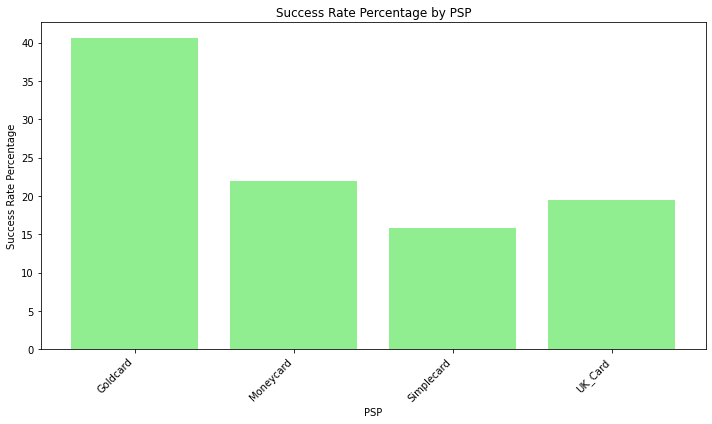

In [33]:
# Bar plot for success rate percentage by PSP

plt.figure(figsize = (10, 6))
plt.bar(psp_success_ds["PSP"], psp_success_ds["success_rate_psp_percentage"], color = 'lightgreen')
plt.xlabel('PSP')
plt.ylabel('Success Rate Percentage')
plt.title('Success Rate Percentage by PSP')
plt.xticks(rotation = 45, ha = 'right')  
plt.tight_layout()
plt.show()

In [34]:
# Calculating card success rates

merged_ds["success_rate_card"] = merged_ds.groupby(['card'])[['success']].transform('mean')
card_rates = merged_ds[["card", "success_rate_card"]]
card_success_ds = card_rates.groupby(["card"])[["success_rate_card"]].mean().reset_index()
card_success_ds["success_rate_card_percentage"] = card_success_ds["success_rate_card"] * 100
display(card_success_ds)

,card,success_rate_card,success_rate_card_percentage
0,Diners,0.223247,22.324723
1,Master,0.194252,19.425156
2,Visa,0.208756,20.875624


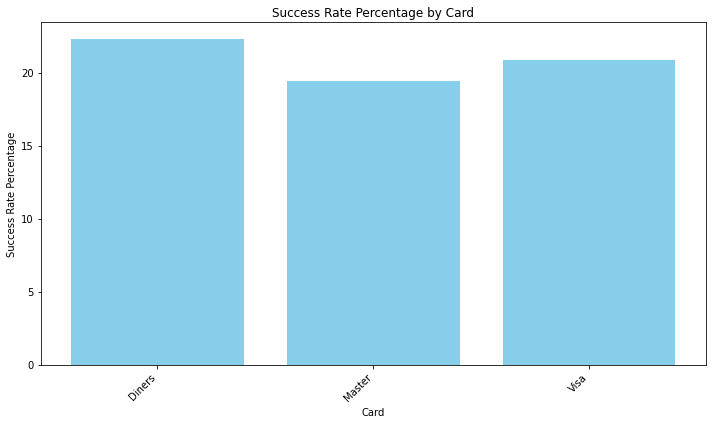

In [35]:
# Bar plot for success rate percentage by card

plt.figure(figsize = (10, 6))
plt.bar(card_success_ds["card"], card_success_ds["success_rate_card_percentage"], color = 'skyblue')
plt.xlabel('Card')
plt.ylabel('Success Rate Percentage')
plt.title('Success Rate Percentage by Card')
plt.xticks(rotation = 45, ha = 'right')  
plt.tight_layout()
plt.show()

In [36]:
# Calculating country success rates

merged_ds["success_rate_country"] = merged_ds.groupby(['country'])[['success']].transform('mean')
country_rates = merged_ds[["country", "success_rate_country"]]
country_success_ds = country_rates.groupby(["country"])[["success_rate_country"]].mean().reset_index()
country_success_ds["success_rate_country_percentage"] = country_success_ds["success_rate_country"] * 100
display(country_success_ds)

,country,success_rate_country,success_rate_country_percentage
0,Austria,0.204969,20.496894
1,Germany,0.201696,20.169626
2,Switzerland,0.206025,20.602480


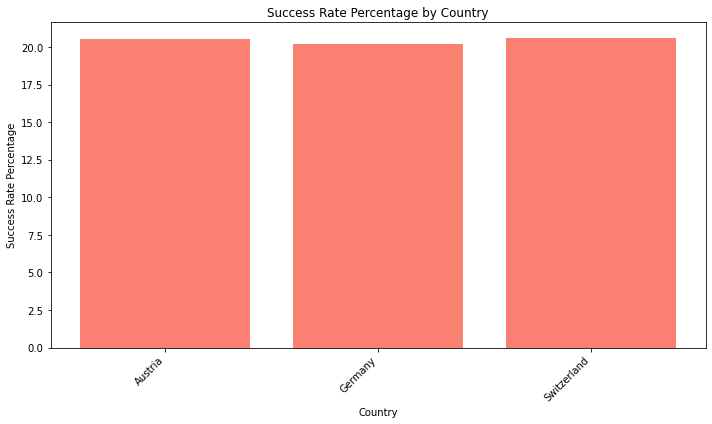

In [37]:
# Bar plot for success rate percentage by country

plt.figure(figsize = (10, 6))
plt.bar(country_success_ds["country"], country_success_ds["success_rate_country_percentage"], color = 'salmon')
plt.xlabel('Country')
plt.ylabel('Success Rate Percentage')
plt.title('Success Rate Percentage by Country')
plt.xticks(rotation = 45, ha = 'right')  
plt.tight_layout()
plt.show()

In [38]:
# Calculating 3D Secured success rates

secured_3d_rates = merged_ds.groupby('3D_secured')['success'].mean()
print(secured_3d_rates)

3D_secured
0    0.189879
1    0.245873
Name: success, dtype: float64


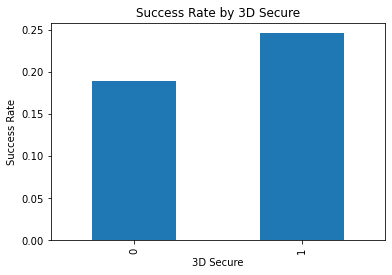

In [39]:
# Bar plot for 3D secured

secured_3d_rates.plot(kind = "bar")
plt.title('Success Rate by 3D Secure')
plt.xlabel('3D Secure')
plt.ylabel('Success Rate')
plt.show()

In [40]:
# Creating a DataFrame for first payment attempt

first_attempt_ds = merged_ds[merged_ds["number_of_attempts"] == 1][["success"]].value_counts().reset_index(name = "transaction_count")
display(first_attempt_ds)

,success,transaction_count
0,0,21639
1,1,5653


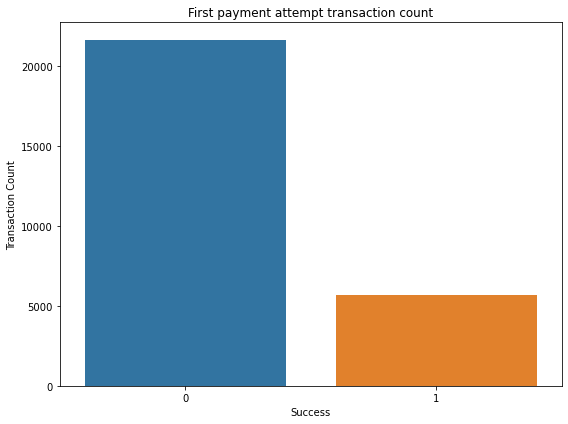

In [41]:
# Bar plot for transaction count

plt.figure(figsize=(8, 6))
sns.barplot(x = "success", y = "transaction_count", data = first_attempt_ds)
plt.xlabel('Success')
plt.ylabel('Transaction Count')
plt.title('First payment attempt transaction count')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Amount by Country and Success')

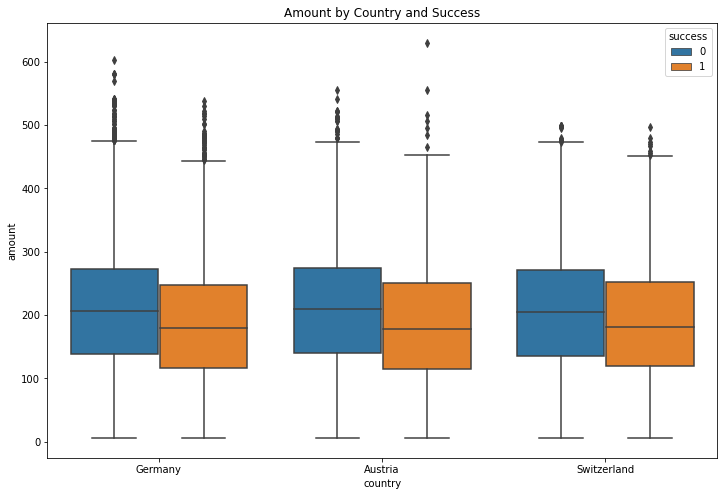

In [42]:
# Box plot of amount by country

plt.figure(figsize=(12, 8))
sns.boxplot(data = merged_ds, x = "country", y = "amount", hue = "success")
plt.title("Amount by Country and Success")

Text(0.5, 1.0, 'Amount by PSP and Success')

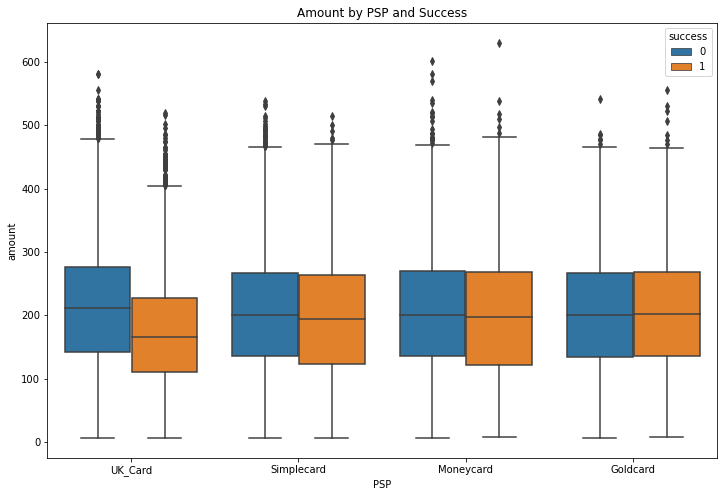

In [43]:
# Box plot of amount by PSP

plt.figure(figsize = (12,8))
sns.boxplot(data = merged_ds, x = "PSP", y = "amount", hue = "success")
plt.title("Amount by PSP and Success")

Text(0.5, 1.0, 'Amount by Card and Success')

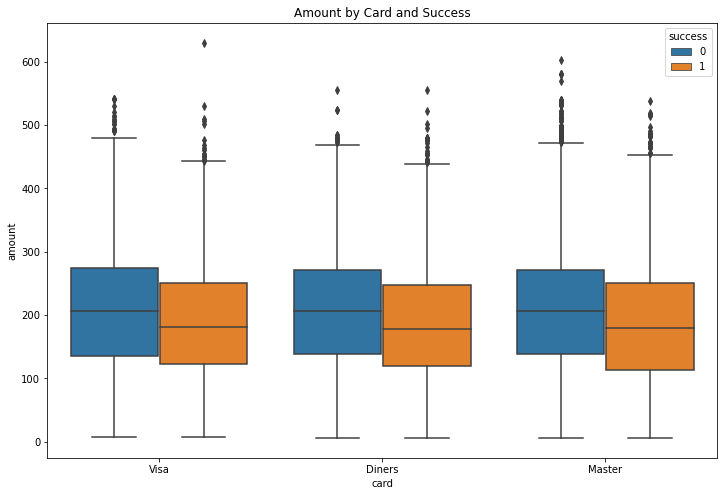

In [44]:
# Box plot of amount by card

plt.figure(figsize = (12,8))
sns.boxplot(data = merged_ds, x = "card", y = "amount", hue = "success")
plt.title("Amount by Card and Success")

Text(0.5, 1.0, 'Amount by Success')

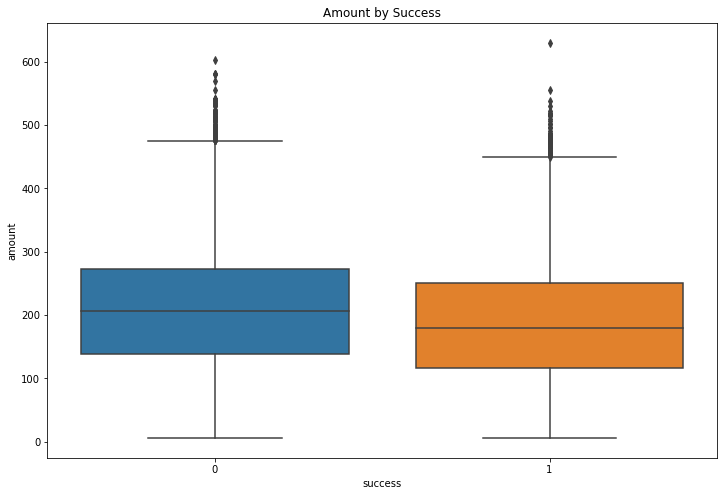

In [45]:
# Box plot of amount by success

plt.figure(figsize = (12,8))
sns.boxplot(data = merged_ds, x = "success", y = "amount")
plt.title("Amount by Success")

In [46]:
# Extracting all the numeric columns

numeric_cols = merged_ds.select_dtypes(include = ['int64', 'float64']).columns
numeric_ds = merged_ds[numeric_cols]

In [47]:
# Calculating the correlation matrix

correlation_matrix = numeric_ds.corr()

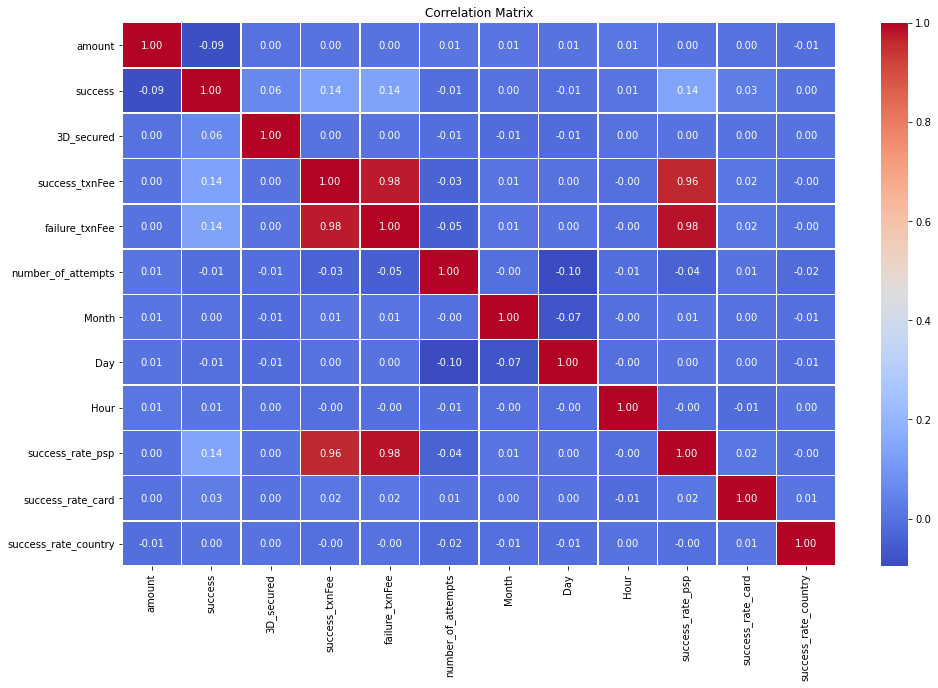

In [48]:
# Plotting the heatmap

plt.figure(figsize = (16, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", linewidths = .5)
plt.title("Correlation Matrix")
plt.show()

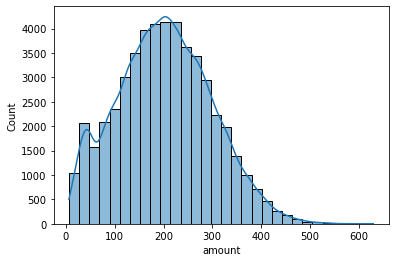

In [49]:
# Plotting histogram for amount

sns.histplot(merged_ds, x = "amount", bins = 30, kde = True)
plt.show()

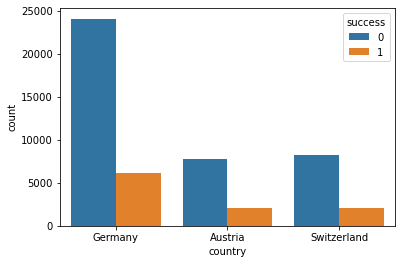

In [50]:
# Count plot for success by country

country_cp = sns.countplot(data = merged_ds, x = "country", hue = "success")
plt.show()

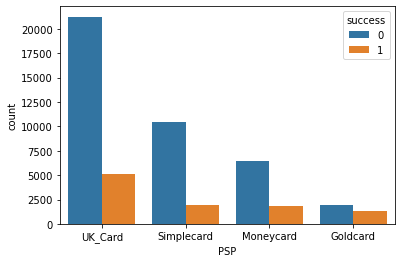

In [51]:
# Count plot for success by psp

psp_cp = sns.countplot(data = merged_ds, x = "PSP", hue = "success")
plt.show()

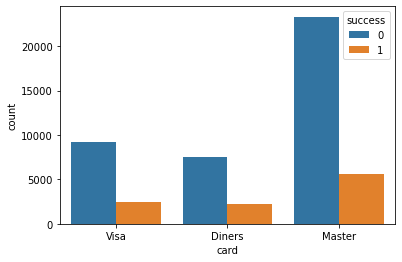

In [52]:
# Count plot for success by card

card_cp = sns.countplot(data = merged_ds, x = "card", hue = "success")
plt.show()

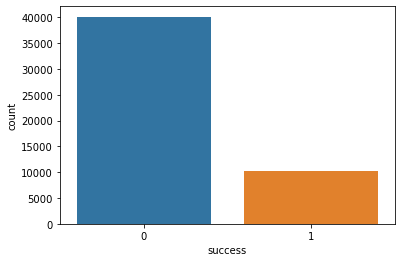

In [53]:
# Count plot for success

success_cp = sns.countplot(data = merged_ds, x = "success")
plt.show()

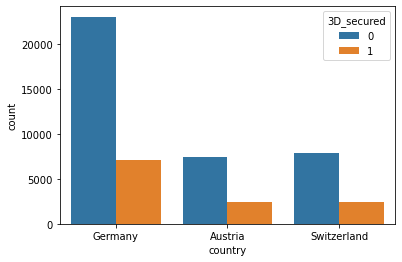

In [54]:
# Count plot of 3D secured by country

country_3d = sns.countplot(data = merged_ds, x = "country", hue = "3D_secured")
plt.show()

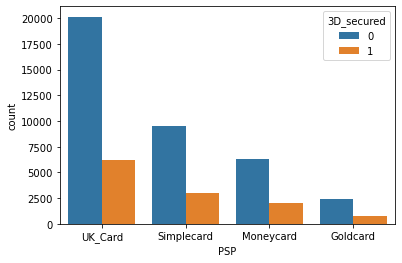

In [55]:
# Count plot of 3D secured by psp

psp_3d = sns.countplot(data = merged_ds, x = "PSP", hue = "3D_secured")
plt.show()

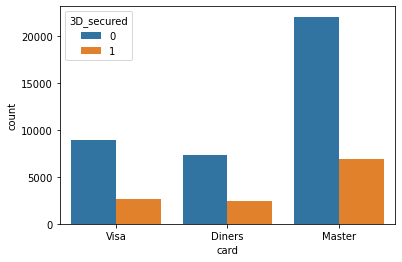

In [56]:
# Count plot of 3D secured by country

card_3d = sns.countplot(data = merged_ds, x = "card", hue = "3D_secured")
plt.show()

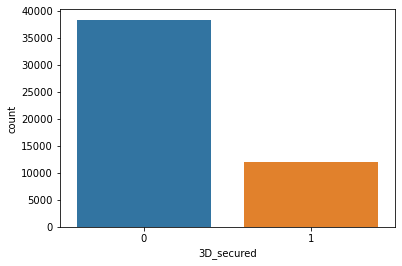

In [57]:
# Count plot for 3D secured

secured_3d = sns.countplot(data = merged_ds, x = "3D_secured")
plt.show()

In [58]:
# Displaying the number of attempts

attempts_count = merged_ds['number_of_attempts'].value_counts()
print(attempts_count)

1     27292
2     12306
3      5710
4      2655
5      1247
6       608
7       287
8       144
9        79
10        1
Name: number_of_attempts, dtype: int64


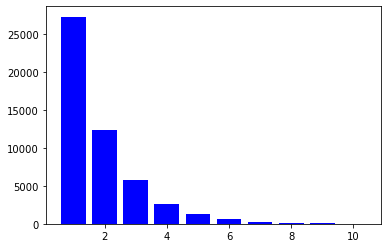

In [59]:
# Bar plot for attempt count
ac_plot = plt.bar(attempts_count.index, attempts_count.values, color = 'blue')
plt.show()

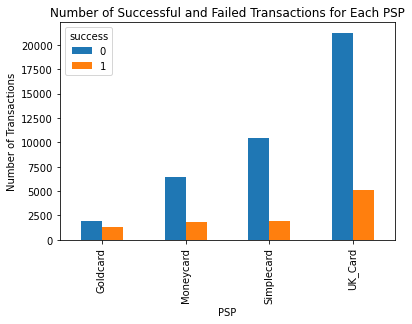

In [60]:
# Bar plot for successful and failed transactions for PSPs

merged_ds.groupby('PSP')['success'].value_counts().unstack().plot(kind = 'bar')
plt.title('Number of Successful and Failed Transactions for Each PSP')
plt.xlabel('PSP')
plt.ylabel('Number of Transactions')
plt.show()

## Model Building and Evaluation

In [61]:
# Separating the target variable from the other features

X = he_ds.drop(["tmsp", "success"], axis = 1)
y = he_ds["success"]

In [62]:
# Splitting the train and test set

from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 50)

In [63]:
# Importing the necessary libraries

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb

In [64]:
# Data preprocessing

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [65]:
# Fitting logistic regression

lr_model = LogisticRegression(solver = 'liblinear')

In [66]:
# Defining hyperparameters

param_grid = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}

In [67]:
# Performing grid search

grid_search = GridSearchCV(lr_model, param_grid, scoring = 'accuracy', cv = 5)
grid_search.fit(X_train_scaled, y_train)
gs_model = grid_search.best_estimator_

In [68]:
# Defining a function for evaluation

def model_evaluation(gs_model, X, y, dataset):
    y_pred = gs_model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average = 'weighted')
    recall = recall_score(y, y_pred, average = 'weighted')
    f1 = f1_score(y, y_pred, average = 'weighted')
    cm = confusion_matrix(y, y_pred)

    print(f"{dataset} set:")
    print("-" * 100)
    print("Accuracy:", accuracy)
    print("-" * 100)
    print("Precision:", precision)
    print("-" * 100)
    print("Recall:", recall)
    print("-" * 100)
    print("F1 Score:", f1) 
    print("-" * 100)
    print("Confusion Matrix:")
    print(cm)

In [69]:
# Evaluating model on the training set

model_evaluation(gs_model, X_train_scaled, y_train, "Training")

Training set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.7956684797456722
----------------------------------------------------------------------------------------------------
Precision: 0.7484095280543437
----------------------------------------------------------------------------------------------------
Recall: 0.7956684797456722
----------------------------------------------------------------------------------------------------
F1 Score: 0.7101093822773492
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[31915    95]
 [ 8132   121]]


In [70]:
# Evaluating model on the test set

model_evaluation(gs_model, X_test_scaled, y_test, "Test")

Test set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.8042916749453606
----------------------------------------------------------------------------------------------------
Precision: 0.7549370138161793
----------------------------------------------------------------------------------------------------
Recall: 0.8042916749453606
----------------------------------------------------------------------------------------------------
F1 Score: 0.7219408045614462
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[8067   24]
 [1946   29]]


In [71]:
# XGBoost classifier

xgb_cla = xgb.XGBClassifier()
xgb_cla.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [72]:
# Evaluating model on the training set

model_evaluation(xgb_cla, X_train_scaled, y_train, "Training")

Training set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.8257953952760599
----------------------------------------------------------------------------------------------------
Precision: 0.8287803423603577
----------------------------------------------------------------------------------------------------
Recall: 0.8257953952760599
----------------------------------------------------------------------------------------------------
F1 Score: 0.7778995982696215
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[31728   282]
 [ 6732  1521]]


In [73]:
# Evaluating model on the test set

model_evaluation(xgb_cla, X_test_scaled, y_test, "Test")

Test set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.8032982316709716
----------------------------------------------------------------------------------------------------
Precision: 0.7515867195629772
----------------------------------------------------------------------------------------------------
Recall: 0.8032982316709716
----------------------------------------------------------------------------------------------------
F1 Score: 0.7439999101120227
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[7910  181]
 [1799  176]]


In [74]:
# Decision tree classifier

dec_tre_cla = DecisionTreeClassifier().fit(X_train_scaled, y_train)

In [75]:
# Evaluating model on the training set

model_evaluation(dec_tre_cla, X_train_scaled, y_train, "Training")

Training set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.99987581650647
----------------------------------------------------------------------------------------------------
Precision: 0.9998758359010496
----------------------------------------------------------------------------------------------------
Recall: 0.99987581650647
----------------------------------------------------------------------------------------------------
F1 Score: 0.999875802540953
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[32010     0]
 [    5  8248]]


In [76]:
# Evaluating model on the test set

model_evaluation(dec_tre_cla, X_test_scaled, y_test, "Test")

Test set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.7024637393204848
----------------------------------------------------------------------------------------------------
Precision: 0.7118574444008502
----------------------------------------------------------------------------------------------------
Recall: 0.7024637393204848
----------------------------------------------------------------------------------------------------
F1 Score: 0.7069975152057846
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[6509 1582]
 [1413  562]]


In [77]:
# Random forest classifier

ran_for_cla = RandomForestClassifier().fit(X_train_scaled, y_train)

In [78]:
# Evaluating model on the training set

model_evaluation(ran_for_cla, X_train_scaled, y_train, "Training")

Training set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.99987581650647
----------------------------------------------------------------------------------------------------
Precision: 0.999875816784923
----------------------------------------------------------------------------------------------------
Recall: 0.99987581650647
----------------------------------------------------------------------------------------------------
F1 Score: 0.9998758081286186
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[32009     1]
 [    4  8249]]


In [79]:
# Evaluating model on the test set

model_evaluation(ran_for_cla, X_test_scaled, y_test, "Test")

Test set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.7913769123783032
----------------------------------------------------------------------------------------------------
Precision: 0.7303896410424091
----------------------------------------------------------------------------------------------------
Recall: 0.7913769123783032
----------------------------------------------------------------------------------------------------
F1 Score: 0.7406537888620847
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[7756  335]
 [1765  210]]


In [80]:
# Ada boost classifier

ada_boo_cla = AdaBoostClassifier().fit(X_train_scaled, y_train)

In [81]:
# Evaluating model on the training set

model_evaluation(ada_boo_cla, X_train_scaled, y_train, "Training")

Training set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.7953456026624941
----------------------------------------------------------------------------------------------------
Precision: 0.7405682660848305
----------------------------------------------------------------------------------------------------
Recall: 0.7953456026624941
----------------------------------------------------------------------------------------------------
F1 Score: 0.7124804741582997
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[31844   166]
 [ 8074   179]]


In [82]:
# Evaluating model on the test set

model_evaluation(ada_boo_cla, X_test_scaled, y_test, "Test")

Test set:
----------------------------------------------------------------------------------------------------
Accuracy: 0.8044903636002384
----------------------------------------------------------------------------------------------------
Precision: 0.7543650467290139
----------------------------------------------------------------------------------------------------
Recall: 0.8044903636002384
----------------------------------------------------------------------------------------------------
F1 Score: 0.7253699354666601
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[8050   41]
 [1927   48]]
